In [135]:
import tensorflow as tf
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import os
import copy
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt

In [136]:
# Conf
langs = ['eng', 'deu', 'hun']

Read embeddings and indices

In [137]:
fold = '/home/eszti/projects/dipterv/notebooks/panlex/train_try/t0'

d_models = dict()
for l in langs:
    fn = os.path.join(fold, '{}.vec'.format(l))
    model = KeyedVectors.load_word2vec_format(fn, binary=False)
    model.syn0 /= np.sqrt((model.syn0**2).sum(1))[:, None]
    d_models[l] = model

In [138]:
# test
print(d_models['hun'].syn0.shape)
print(d_models['hun'].index2word)

np.linalg.norm(d_models['hun']['kutya'])

(4, 300)
['kutya', 'macska', 'nap', 'hold']


1.0

Read words pairs from tsv

In [139]:
def read_word_pairs_tsv(fn, id1, id2):
    with open(fn) as f:
        lines = f.readlines()
        data = [(line.split()[id1], line.split()[id2]) for i, line in enumerate(lines) if i > 0]
    return data

def wp_list_2_dict(lang_pair, wp_l):
    l1 = lang_pair[0]
    l2 = lang_pair[1]
    l12 = dict()
    l21 = dict()
    for (w1, w2) in wp_l:
        if w1 not in l12:
            l12[w1] = [w2]
        else:
            l12[w1] += w2
        if w2 not in l21:
            l21[w2] = [w1]
        else:
            l21[w2] += w1
    return l12, l21

In [140]:
fold = '/home/eszti/projects/dipterv/notebooks/panlex/train_try/t0'
id1 = 2
id2 = 3
# Dict for word pairs
d_wps = dict()
done = set()
for lang1 in langs:
    for lang2 in langs:
        lang_pair = tuple(sorted([lang1, lang2]))
        if lang1 == lang2 or lang_pair in done:
            continue
        done.add(lang_pair)
        l1 = lang_pair[0]
        l2 = lang_pair[1]
        fn = os.path.join(fold, '{0}_{1}.tsv'.format(l1, l2))
        data = read_word_pairs_tsv(fn, id1, id2)
        d_wps[lang_pair] = data

d_dict = dict()
for ((l1, l2), wp_l) in d_wps.items():
    l12, l21 = wp_list_2_dict((l1, l2), wp_l)
    d_dict[(l1, l2)] = l12
    d_dict[(l2, l1)] = l21

In [141]:
d_dict

{('deu', 'eng'): {'hund': ['dog'],
  'katze': ['cat'],
  'mond': ['moon'],
  'sonne': ['sun']},
 ('deu', 'hun'): {'hund': ['kutya'],
  'katze': ['macska'],
  'mond': ['hold'],
  'sonne': ['nap']},
 ('eng', 'deu'): {'cat': ['katze'],
  'dog': ['hund'],
  'moon': ['mond'],
  'sun': ['sonne']},
 ('eng', 'hun'): {'cat': ['macska'],
  'dog': ['kutya'],
  'moon': ['hold'],
  'sun': ['nap']},
 ('hun', 'deu'): {'hold': ['mond'],
  'kutya': ['hund'],
  'macska': ['katze'],
  'nap': ['sonne']},
 ('hun', 'eng'): {'hold': ['moon'],
  'kutya': ['dog'],
  'macska': ['cat'],
  'nap': ['sun']}}

Calculate precision

In [142]:
# model_src_tr : source language translated embeddings
# model_tar : target language embeddings
# dict_scr_2_tar : dictionary from source to target
def calc_precision(precs, model_src_tr, model_tar, dict_scr_2_tar, verbose=False):
    W_src_tr = model_src_tr.syn0
    W_tar = model_tar.syn0
    idx_src_tr = model_src_tr.index2word
    idx_tar = model_tar.index2word
    
    cos_mx = cosine_similarity(W_src_tr, W_tar)
    sim_mx = np.argsort(-cos_mx)
    max_prec = max(precs)
    prec_cnt = np.zeros(shape=(1, max_prec))
    if verbose:
        print('word: \ttranslations in dict: \tclosest words after translation: \t')
    for i, r in enumerate(sim_mx):
        key_word = idx_src_tr[i]
        value_words = dict_scr_2_tar[key_word]
        closest_words = []
        for j in range(max_prec):       
            ans = np.where(r==j)
            idx_orig = ans[0][0]
            word = idx_tar[idx_orig]
            closest_words.append(word)
            if word in value_words:
                prec_cnt[0][j] = prec_cnt[0][j] + 1
        if verbose:
            print('{}"\t{}\t{}'.format(key_word, value_words, closest_words))
    if verbose:
        print(prec_cnt)
    prec_pcnts = []
    for i, val in enumerate(precs):
        sum_hit = np.sum(prec_cnt[0][0:val])
        pcnt = float(sum_hit)/sim_mx.shape[0]
        if verbose:
            print('prec {} : {}'.format(val, pcnt))
        prec_pcnts.append(pcnt)
    return prec_pcnts

Testing precision calculation

In [143]:
# Precision without translation
calc_precision([1], d_models['eng'], d_models['deu'], d_dict[('eng', 'deu')], verbose=True)
calc_precision([2], d_models['eng'], d_models['deu'], d_dict[('eng', 'deu')], verbose=True)
calc_precision([3], d_models['eng'], d_models['deu'], d_dict[('eng', 'deu')], verbose=True)
calc_precision([4], d_models['eng'], d_models['deu'], d_dict[('eng', 'deu')], verbose=True)

word: 	translations in dict: 	closest words after translation: 	
dog"	['hund']	['mond']
cat"	['katze']	['mond']
sun"	['sonne']	['hund']
moon"	['mond']	['katze']
[[ 0.]]
prec 1 : 0.0
word: 	translations in dict: 	closest words after translation: 	
dog"	['hund']	['mond', 'hund']
cat"	['katze']	['mond', 'katze']
sun"	['sonne']	['hund', 'katze']
moon"	['mond']	['katze', 'hund']
[[ 0.  2.]]
prec 2 : 0.5
word: 	translations in dict: 	closest words after translation: 	
dog"	['hund']	['mond', 'hund', 'sonne']
cat"	['katze']	['mond', 'katze', 'sonne']
sun"	['sonne']	['hund', 'katze', 'sonne']
moon"	['mond']	['katze', 'hund', 'sonne']
[[ 0.  2.  1.]]
prec 3 : 0.75
word: 	translations in dict: 	closest words after translation: 	
dog"	['hund']	['mond', 'hund', 'sonne', 'katze']
cat"	['katze']	['mond', 'katze', 'sonne', 'hund']
sun"	['sonne']	['hund', 'katze', 'sonne', 'mond']
moon"	['mond']	['katze', 'hund', 'sonne', 'mond']
[[ 0.  2.  1.  1.]]
prec 4 : 1.0


[1.0]

Doing training

In [144]:
# langs : list containing sil codes of languages, tf_T follows the same order
# d_models : dictionary, lang - embedding (KeyedVectors)
# d_wps : dictiorary, lang_pair - wordpair list
# dim : dimensiion of embedding
# epochs : epochs to run
# precs_to_calc : list of precisions to calculate, e.g. [1,3,5] if we want Precision @1, @3, @5
# iters : optional, break after n update
# lr : learning rate
# svd : whether to do svd regularization
# svd_f : how often regularize
# verbose : print out details
def train(langs, d_models, d_wps, dim, epochs, precs_to_calc, iters=None, lr=0.3, svd=False, svd_f=1, verbose=False):
    nb_langs = len(langs)

    # Init graphs
    graph = tf.Graph()
    with graph.as_default():
        # TF variables 
        # Placeholder for 2 words
        tf_w1 = tf.placeholder(tf.float32, shape=[None, dim])
        tf_w2 = tf.placeholder(tf.float32, shape=[None, dim])
        # Placeholder for indexing the T matrix
        tf_idx_l1 = tf.placeholder(tf.int32)
        tf_idx_l2 = tf.placeholder(tf.int32)
        # Translation matrices
        tf_T = tf.Variable(tf.truncated_normal([nb_langs, dim, dim]))
        
        # SVD reguralization
        tf_s1, tf_U1, tf_V1 = tf.svd(tf_T[tf_idx_l1], full_matrices=True, compute_uv=True)
        updated_1 = tf.assign(tf_T[tf_idx_l1], tf.matmul(tf_U1, tf_V1))
        tf_s2, tf_U2, tf_V2 = tf.svd(tf_T[tf_idx_l2], full_matrices=True, compute_uv=True)
        updated_2 = tf.assign(tf_T[tf_idx_l2], tf.matmul(tf_U2, tf_V2))

        # Loss
        tf_T1 = tf.matmul(tf_w1, tf_T[tf_idx_l1])
        tf_T2 = tf.matmul(tf_w2, tf_T[tf_idx_l2])
        tf_T1_n = tf.nn.l2_normalize(tf_T1, dim=1)
        tf_T2_n = tf.nn.l2_normalize(tf_T2, dim=1)
        loss = tf.matmul(tf_T1_n, tf.transpose(tf_T2_n))
        loss = -loss
        
        # Applying optimizer, Todo: try different optimizers!!
        # https://www.tensorflow.org/api_guides/python/train#Optimizers 
        optimizer = tf.train.AdagradOptimizer(lr).minimize(loss)

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()

        j = 0
        lc_arr = []
        precs_arr = []
        for i in range(epochs):
            loss_arr = []
            for ((l1, l2), wp_l) in d_wps.items():
                loss_arr_l = []
                idx_l1 = langs.index(l1)
                idx_l2 = langs.index(l2)
                k = 0
                for (w1, w2) in wp_l:
                    emb1 = d_models[l1][w1].reshape((1, 300))
                    emb2 = d_models[l2][w2].reshape((1, 300))
                    # Todo: if we add "or j == 0" for some reason it's better in this mock example
                    if (svd and i % svd_f == 0) or j == 0:
                        _, l, _, _, T = session.run([optimizer, loss, updated_1, updated_2, tf_T], 
                                                      feed_dict={tf_w1 : emb1, 
                                                                 tf_w2 : emb2, 
                                                                 tf_idx_l1 : idx_l1, 
                                                                 tf_idx_l2 : idx_l2})
                    else:
                        _, l, T = session.run([optimizer, loss, tf_T],
                                             feed_dict={tf_w1 : emb1, 
                                                        tf_w2 : emb2, 
                                                        tf_idx_l1 : idx_l1, 
                                                        tf_idx_l2 : idx_l2})
                    j += 1
                    k += 1
                    loss_arr.append(-l[0][0])
                    loss_arr_l.append(-l[0][0])
                    if iters is not None and j == iters:
                        break
                loss_np_arr_l = np.asarray(loss_arr_l)
                if verbose:
                    print('{0} - {1}\tavg loss: {2}'.format(l1, l2, np.average(loss_np_arr_l)))
                if iters is not None and j == iters:
                    break
                    
            # Monitoring for learning curve
            loss_np_arr = np.asarray(loss_arr)
            loss_epoch_avg = np.average(loss_np_arr)
            if verbose:
                print('{0}\tavg loss: {1}'.format(i, loss_epoch_avg))
            lc_arr.append(loss_epoch_avg)
            
            # Calculate precision
            e_prec_l = []
            for ((l1, l2), _) in d_wps.items():
                m1 = copy.deepcopy(d_models[l1])
                m2 = copy.deepcopy(d_models[l2])
                idx_l1 = langs.index(l1)
                idx_l2 = langs.index(l2)
                T1 = T[idx_l1]
                T2 = T[idx_l2]
                m1.syn0 = np.dot(m1.syn0, T1)
                m2.syn0 = np.dot(m2.syn0, T2)
                precs_1 = calc_precision(precs_to_calc, m1, m2, d_dict[(l1, l2)], verbose=False)
                precs_2 = calc_precision(precs_to_calc, m2, m1, d_dict[(l2, l1)], verbose=False)
                e_prec_l.append(((l1, l2), precs_1))
                e_prec_l.append(((l2, l1), precs_2))
            precs_arr.append(e_prec_l)
    return T, lc_arr, precs_arr

Testing train function

In [145]:
T, lc, precs = train(langs, d_models, d_wps, 300, 20, [1, 2])
print(precs[-1])
# Check rank loss
T1 = T[0]
# print(np.linalg.svd(T1, compute_uv=False, full_matrices=False))

[(('deu', 'eng'), [0.75, 1.0]), (('eng', 'deu'), [0.75, 1.0]), (('eng', 'hun'), [0.75, 1.0]), (('hun', 'eng'), [0.75, 1.0]), (('deu', 'hun'), [0.75, 1.0]), (('hun', 'deu'), [0.75, 1.0])]


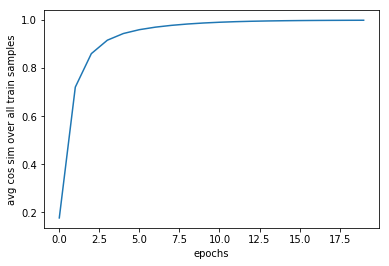

In [146]:
# Display learning curve
plt.plot(lc)
plt.ylabel('avg cos sim over all train samples')
plt.xlabel('epochs')
plt.show()

In [147]:
m1 = copy.deepcopy(d_models['eng'])
m2 = copy.deepcopy(m1)

W = copy.deepcopy(m2.syn0)
T = np.random.rand(300,300)
# print(W)
# print(T)
m2.syn0 = np.dot(W, T)
# print(m2.syn0)
print(m1.most_similar('dog'))
print(m2.most_similar('dog'))

[('cat', 0.6380517482757568), ('moon', 0.2543850839138031), ('sun', 0.1620684415102005)]
[('cat', 0.5031781196594238), ('moon', 0.41951072216033936), ('sun', -0.45986729860305786)]
